# Homework 3 Beginnings:
Starting with the notes from class, lecture 5: Black Hole Imaging, we have a set of ray equations for a schwarzschild metric.

### Initialization factors:

spin: $0 < a_0 < 1$

inclination: $0 < \theta_0 < \pi$

angular momentum: $L$


### Notation:

The Sky Plane, $S$ with cartesian coordinates $(X,Y)$

Y: Parallel to the projection of hole spin on the sky

Momentum vector: $k = \frac{dx}{d\xi}$ with affine parameter $\xi = 0$ at $S$ and $\xi < 0$ near the BH.

Introduce coordine $s = \frac{1}{r}$ and $\mu = cos\theta$

A parameter of the hole is related to the angular momentum by $a = cJ/GM^2$, we will measure this length in terms of mass to make it unitless.

### Equations needing Evaluation
For now we are interested in stationary sources, so we have dropped the $t$ parameter.

**Energy and angular momentum are conserved along the ray:*

$\mathcal{E} = -k_t = 1, k^t = \frac{dt}{d\xi} = 1$ at $S$ where $1 << r << D$

$L = r^2 sin^2\theta \frac{d\phi}{d\xi} = r^2 sin^2\theta_0 \frac{d\phi}{dt} = -X sin\theta_0$

**The Carter constant:**

$Q = k_{\theta}^2 + L^2 cot(\theta)-a^2cos^2\theta$

Note, at S, $k_{\theta}= Y$.

### ODEs to solve:
If needing $t$:

$t' = \frac{dt}{d\lambda} = -\frac{\Sigma^2}{\Delta}(1-\omega L)$

$t' = -\frac{1+as^2(a+2as-2Ls+a(1+s(-2+a^2s))\mu^2}{s^2(1+s(-2+a^2s))}$

$\phi$ **Equation:**

$\phi' = \frac{d\phi}{d\lambda}$

$\phi' = \frac{L+2as-2Ls+as(-2+aLs)\mu^2}{(1-s(-2+a^2s))(-1+\mu^2)}$

$\mu$ **Equation:**

$\mu'' = -\mu(L^2+Q+a^2(-1+2\mu^2))$

$s$ **Equation:**

$s'' = s(-6aLs+(-1+3s)(L^2+Q)+a^2(1+s(3-2sQ)))$

### Intensity Tracking

We can evolve the intensity along the ray in the B frame according to:

$dI/dl = j-\kappa l$ where $dl = (\frac{\rho^2}{\Delta} (k^r)^2+\rho^2 (k^{\sigma})^2+\omega^2 (k^\phi)^2)^{1/2}d\xi$

The tangent vector is 

$k = \frac{dx}{d\xi} = \frac{-1}{\rho^2} x$

The redshift factor will be obtained by taking the emissivity frame (the rest frame) into the ZAMO frame (by four velocity, $u$) and then use another lorentz transformation to the B coordinates we're already in.

$\mathcal{D} = (k^{\hat{t}'})^{-1}$

$k^{\hat{\gamma}'} = L^{\hat{\gamma}'}_{\hat{\alpha}}L^{\hat{\alpha}}_{\beta}k^{\beta}$

And the intensities are related from the rest emission frame to the local k by $I = \mathcal{D}^3 I'.

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint #ode solver

In [272]:
class bh_vis:
    def __init__(self,size,a0=0.95,inc=np.pi/2,s0=0.01):
        #initialize class
        #size should be odd so we can have a centered origin
        self.XY = np.zeros(size) #image grid
        #may want to rescale x,y into physical units
        self.x = np.linspace(-int((size[1]-1)/2),int((size[1]-1)/2),num=size[1])
        self.y = np.linspace(-int((size[0]-1)/2),int((size[0]-1)/2),num=size[0])
        self.size = size
        self.a0 = a0 #spin/mass parameter
        self.inc = inc
        self.s0 = s0 #sky plane distance in 1/r units
        self.sH = (1-(1-a0**2)**(0.5))/a0**2-self.s0 #s_hole in 1/r units
        
        #in notes is sometimes cosine and sometimes sine:
        self.L = -self.x*np.sin(inc) #an array of momentum based on X coordinate
        
        #may need to check math on this
        self.Q = self.y**2 + self.L**2*(np.cos(inc)/np.sin(inc))**2-a0*np.cos(inc)**2 #Carter constant conserved
        print('Instance initialized:\nsize: {0}\nspin: {1}\ninclination: {2}'.format(size,a0,inc))
        return
    
    def dt_dlam(self,mu,s):
        #returns derivative of s wrt affine parameter
        #pos[0] = x, pos[1] = y pixel location (recall)
        #since a second order ODE, split into first order to solve
        #S = vector of S[0] = s, S[1] = s'

        L = self.L[(self.x==self.pos[0])]
        return -(1+self.a0*s**2*(self.a0+2*self.a0*s-2*L*s+self.a0*(1+s*(-2+self.a0**2*s))*mu**2))/(s**2*(1+s*(-2+self.a0**2*s)))

    def d2s_dlam2(self,S,lam):
        #returns derivative of s wrt affine parameter
        #pos[0] = x, pos[1] = y pixel location (recall)
        #since a second order ODE, split into first order to solve
        #S = vector of S[0] = s, S[1] = s'

        L = self.L[(self.x==self.pos[0])]
        Q = self.Q[(self.y==self.pos[1])]
        return [S[1],S[0]*(-6*self.a0*L*S[0]+(-1+3*S[0])*(L**2+Q)+self.a0**2*(1+S[0]*(3-2*S[0]*Q)))]
    
    def d2mu_dlam2(self,M,lam):
        #returns first order system of equations for second order ODE in mu
        #pos[0] = x, pos[1] = y pixel location
        #M = vector of M[0] = mu, M[1] = mu'
        
        L = self.L[(self.x==self.pos[0])]
        Q = self.Q[(self.y==self.pos[1])]
        return [M[1],-M[0]*(L**2+Q+self.a0**2*(-1+2*M[0]**2))]
    
    def dphi_dlam(self,mu,s):
        #returns first derivative of phi coordinate given mu and s with position
        
        L = self.L[(self.x==self.pos[0])]
        #Q = self.Q[(self.y==self.pos[1])]
        return (L+2*self.a0*s-2*L*s+self.a0*s*(-2+self.a0*L*s)*mu**2)/((1+s*(-2+self.a0**2*s))*(-1+mu**2))
     
    
    def twoDtrace(self,pos,lamrange,num=1000,plot=True, **kwargs):
        #perform a 2D trace as seen in cell 182 of the lecture notes,
        #does calculations for a single ray given sky coordinates in position, pos
        #plot phi, mu, s with respect to lambda (affine parameter) for some range
        self.pos = pos #position in x,y space
                
        lam = np.linspace(lamrange[0],lamrange[1],num=num) #lambda
        print('lambda-shape: {}'.format(lam.shape))

        #solve s
        #second order ODE
        s = odeint(self.d2s_dlam2,[self.s0, 1.],lam) #IC, s''(0) = s0, s'(0)=1
        s = np.array(s[:,0])
        print('s-shape: {}'.format(s.shape))
                
        #solve mu
        mu0 = [np.cos(self.inc),self.pos[1]*np.sin(self.inc)] #ICs, mu(0)=cosThet_0, mu'(0) = YsinThet_0
        mu = odeint(self.d2mu_dlam2,mu0,lam)
        mu = np.array(mu[:,0])
        print('mu-shape: {}'.format(mu.shape))

        #solve phi
        phi = np.zeros(num)
        #Do simple Newton Raphson (add derivative*step)
        for i in range(1,num):
            phi[i] = phi[i-1]+self.dphi_dlam(mu[i-1],s[i-1])*(lam[i]-lam[i-1])
        
        print('phi-shape: {}'.format(phi.shape))
        
        #solve for t
        t = np.zeros(num)
        #Do simple Newton Raphson (add derivative*step)
        for i in range(1,num):
            t[i] = t[i-1]+self.dt_dlam(mu[i-1],s[i-1])*(lam[i]-lam[i-1])
        
        print('t-shape: {}'.format(t.shape))
                
        #plot the parameters
        if plot==True:
            plt.figure(figsize=(10,6))
            plt.plot(lam,s,'--',label = r'$s(\lambda)$')
            plt.plot(lam,mu,'-',label = r'$\mu(\lambda)$')
            plt.plot(lam,phi,'-.',label = r'$\phi(\lambda)$')
            plt.grid(True)
            plt.legend(loc='bottom left')
            plt.xlabel(r'Affine Parameter, $\lambda$',fontsize=14)
            plt.title('Ray Tracing for {}'.format(self.pos),fontsize=18)
            plt.ylim([-1,self.sH])
            plt.show()
        
            #TBD, fix azimuth, phi

            #plot them in polar coordinates:
            #plot the parameters
            plt.figure(figsize=(10,6))
            plt.plot(lam,1/s,'--',label = r'$r(\lambda)$')
            plt.plot(lam,np.arccos(mu)*180./np.pi,'-',label = r'$\theta(\lambda)$, degrees')
            plt.plot(lam,phi*180./np.pi,'-.',label = r'$\phi(\lambda)$, degrees')
            plt.grid(True)
            plt.axhline(y=1/self.sH,label=r'$r_H$')
            plt.legend(loc='bottom left')
            plt.xlabel(r'Affine Parameter, $\lambda$',fontsize=14)
            plt.title('Ray Tracing for {}'.format(self.pos),fontsize=18)
            plt.ylim([-200,200])
            plt.show()
        
        return lam, t, s, mu, phi
    
    
    def threeDtrace(self,**kwargs):
        #if we get around to it, plot real image which requires a three dimensional trace
        return 0
    
    def source_init(self,M,disksz=3,T = 10**5, v=3.0*10**16):
        #set up the source, likely an equatorial disk of uniform brightness
        self.Rsch = 2*M; #2GM/c2 in units we're using
        self.disk_r = disksz*self.Rsch; #disk size in units of R_schwarzschild
        self.T = T #disk isothermal temp
        self.v = v #peak emission frequency (picked to be optical)
        print('Written Rsch {0}, disk_r {1}, v {2:e} Hz, T {3}'.format(self.Rsch,self.disk_r,self.v,self.T))
        return
    
    def track_temp(self,r):
        
        #UNFINISHED
        
        #given a ray, what is it's change in temperature from source to observation?
        #the final data point is considered at the surface of the disk if passed.
        rough_nu = self.v
        h = 6.626*10**(-34) #Js
        k = 1.380*10**(-23) #J/K
        n = (np.exp(h*rough_nu/(k*self.T))-1)**(-1) #conserved along ray
        final_nu = self.v*self.get_rf(r[-1]) #get final frequency to get Temp
        T_xy = h*final_nu/(k*np.log(1/n+1))
        return T_xy
    
    @staticmethod
    def get_rf(r):
        #given a ray, what is it's redshift factor?
        #still need to take into account doppler effect eventually
        #the final data point is considered at the surface of the disk if passed.
        rf = np.sqrt(1-2/r)
        return rf
    
        

In [273]:
#example call
test1 = bh_vis((33,33),a0=0.95,inc=np.pi*163./180.,s0=0.01)

print('X Coordinates:')
print(test1.x)

print('Q constant:')
print(test1.Q)

test1.source_init(3,3)


Instance initialized:
size: (33, 33)
spin: 0.95
inclination: 2.844886680750757
X Coordinates:
[-16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.
  12.  13.  14.  15.  16.]
Q constant:
[489.24801644 429.89793407 374.37688926 322.68488203 274.82191238
 230.78798029 190.58308578 154.20722884 121.66040947  92.94262768
  68.05388346  46.99417681  29.76350773  16.36187623   6.7892823
   1.04572594  -0.86879285   1.04572594   6.7892823   16.36187623
  29.76350773  46.99417681  68.05388346  92.94262768 121.66040947
 154.20722884 190.58308578 230.78798029 274.82191238 322.68488203
 374.37688926 429.89793407 489.24801644]
Written Rsch 6, disk_r 18, v 3.000000e+16 Hz, T 100000


lambda-shape: (5000,)
s-shape: (5000,)
mu-shape: (5000,)
phi-shape: (5000,)
t-shape: (5000,)


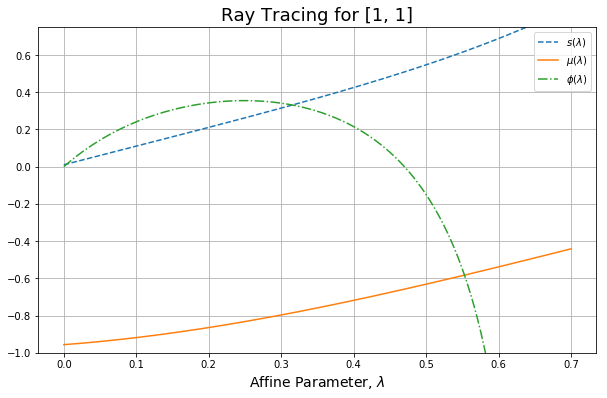

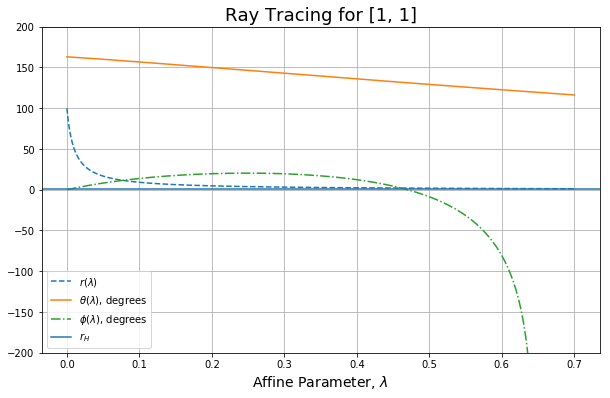

In [282]:
lam, t, s, mu, phi = test1.twoDtrace([1,1],[0,0.7],num=5000)

In [287]:
T = test1.track_temp(1/s[:2000])
print(T)
print(T/test1.T)

print('redshift factor (sans doppler): {0}'.format(bh_vis.get_rf(1/s[2000])))

64281.648374156175
0.6428164837415618
redshift factor (sans doppler): 0.6425875396560474
